In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple

#from Plot_tools import *
from File_tools import *

import pickle

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Read in precip and w data

in_dir  = "/work/wicker/Odin_scr/solo"
out_dir = "/work/wicker/Odin_scr/solo"
prefix  = {"solo": "squall_3km", "wrf": "squall_3km", "cm1": "squall_3km"}

allcape = ("C2000", "C3500")
allshear = ("06", "12", "18")

solo = {}
cm1  = {}
wrf  = {}

for shear in allshear:
    for cape in allcape:
        
        label = "%s_%s" % (cape, shear)
        
        solo_file = str(os.path.join(in_dir, "%s_%s" % (prefix['solo'], label)))
        solo[label] = read_model_fields(solo_file, filename='atmos_hifreq.nc', model_type='fv3_solo', precip_only=True)
        
        wrf_file = str(os.path.join("/work/wicker/WRF/WRF/test/em_quarter_ss", "%s_%s" % (prefix['wrf'], label)))
        wrf[label] = read_model_fields(wrf_file, model_type='wrf', precip_only=True)
         
        cm1_file = str(os.path.join("/work/wicker/Odin_scr/cm1r20.3/run", "%s_%s" % (prefix['cm1'], label)))
        cm1[label] = read_model_fields(cm1_file, model_type='cm1', precip_only=True)
                

Reading:  /work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc 
Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_06/wrfout_d01_0001-01-01_00:00:00 
Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_06/cm1out.nc 
Reading:  /work/wicker/Odin_scr/solo/squall_3km_C3500_06/atmos_hifreq.nc 
Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C3500_06/wrfout_d01_0001-01-01_00:00:00 
Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C3500_06/cm1out.nc 
Reading:  /work/wicker/Odin_scr/solo/squall_3km_C2000_12/atmos_hifreq.nc 
Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C2000_12/wrfout_d01_0001-01-01_00:00:00 
Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C2000_12/cm1out.nc 
Reading:  /work/wicker/Odin_scr/solo/squall_3km_C3500_12/atmos_hifreq.nc 
Reading:  /work/wicker/WRF/WRF/test/em_quarter_ss/squall_3km_C3500_12/wrfout_d01_0001-01-01_00:00:00 
Reading:  /work/wicker/Odin_scr/cm1r20.3/run/squall_3km_C3500_12/cm1

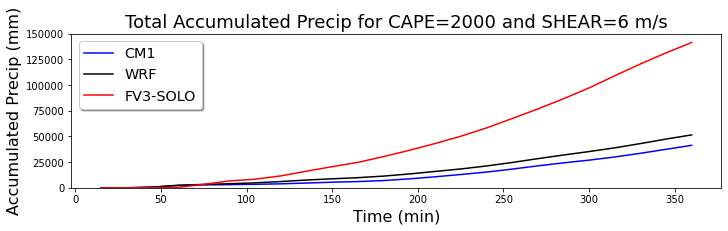

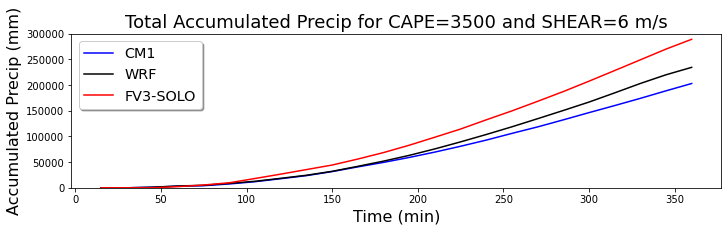

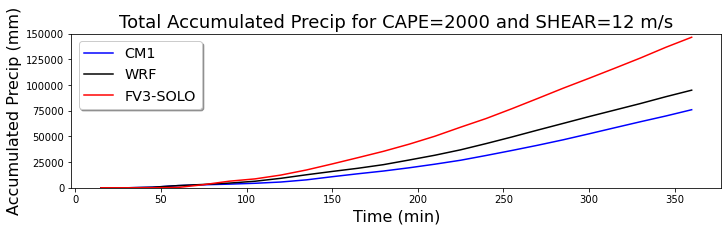

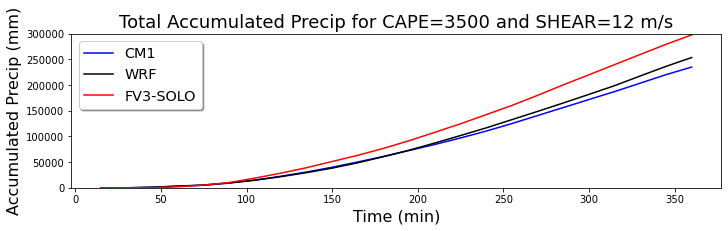

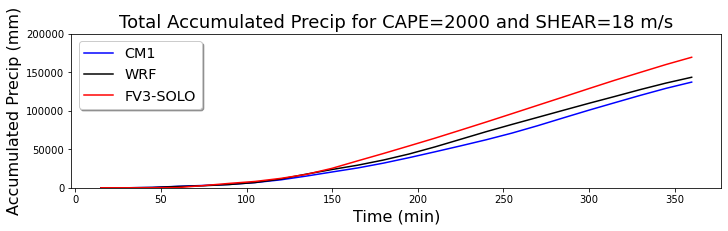

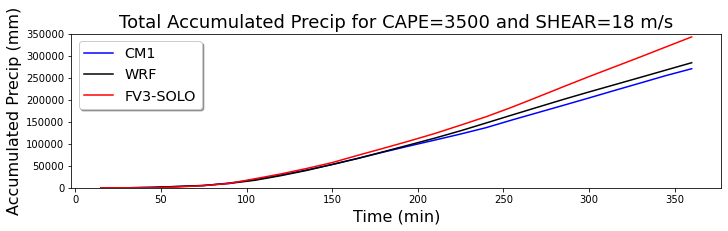

In [5]:
time = 15+15*np.arange(24)
x = np.arange(5)

plim = [[1.5e5, 3.0e5, 3.0e5, 3.5e5, 3.5e5],[1.5e5, 3.0e5, 3.0e5, 3.0e5, 3.25e5], [2.0e5, 3.5e5, 3.0e5, 3.5e5, 3.5e5]]

labels = []
for cape in allcape:
    labels.append("%s" % (cape[1:]))

for m, shear in enumerate(allshear):
    for n, cape in enumerate(allcape):
        label = "%s_%s" % (cape, shear)
        
        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,3))

        ax.plot(time, cm1[label]['acc_precip'].sum(axis=(1,2)), color='b', linestyle='-', label='CM1')
        ax.plot(time, wrf[label]['acc_precip'].sum(axis=(1,2)), color='k', linestyle='-', label='WRF')
        ax.plot(time, solo[label]['acc_precip'].sum(axis=(1,2)), color='r', linestyle='-', label='FV3-SOLO')

        ax.set_ylabel('Accumulated Precip (mm)', fontsize=16)
        ax.set_xlabel('Time (min)', fontsize=16)
        ax.set_ylim(0, plim[m][n])
        ax.set_title('Total Accumulated Precip for CAPE=%d and SHEAR=%d m/s' % (int(cape[1:]), int(shear)), fontsize=18)
        legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
        plt.show()

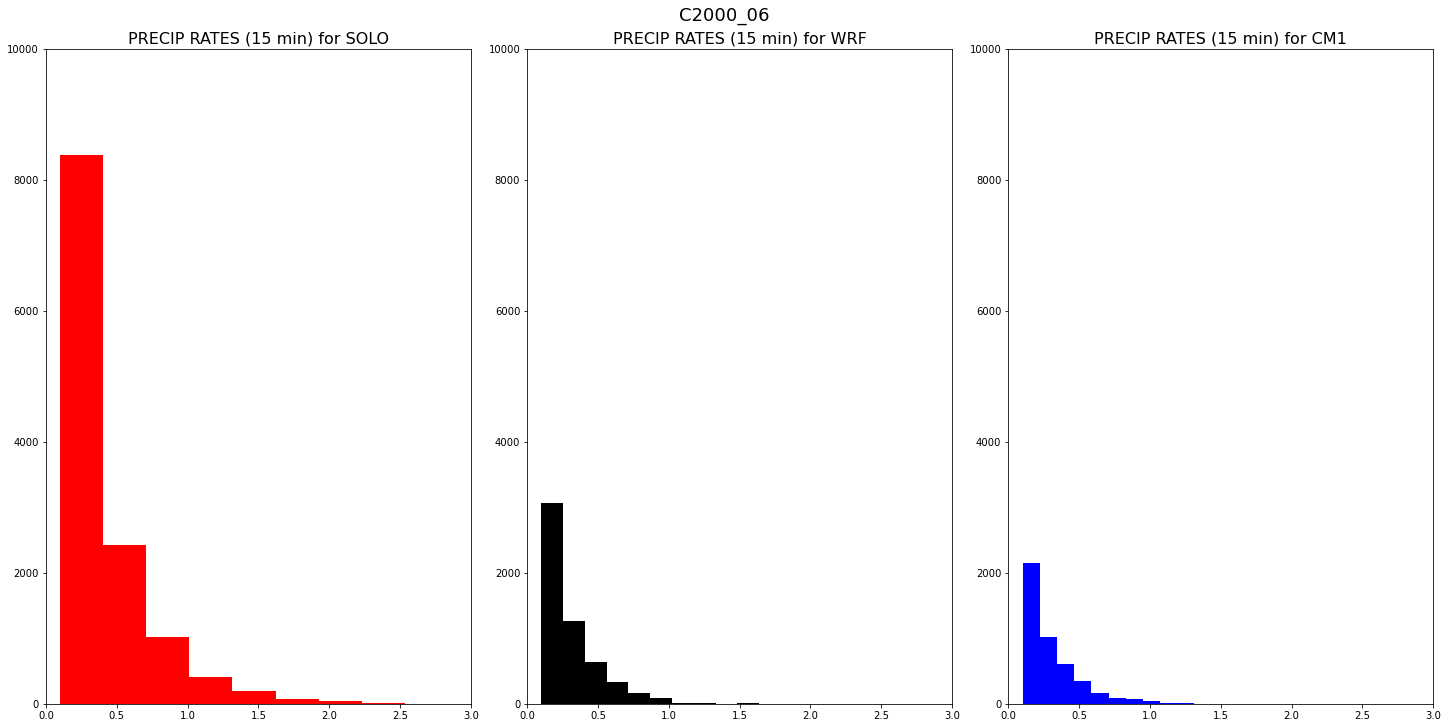

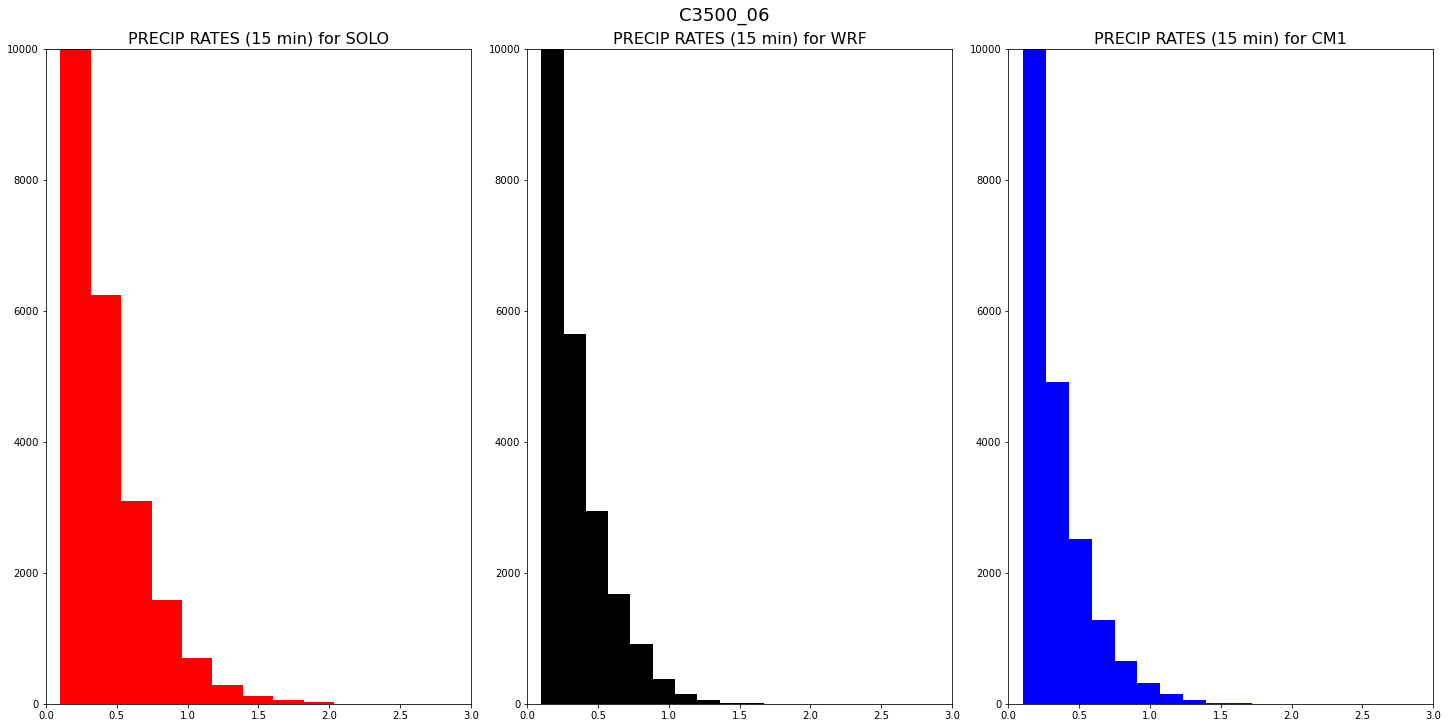

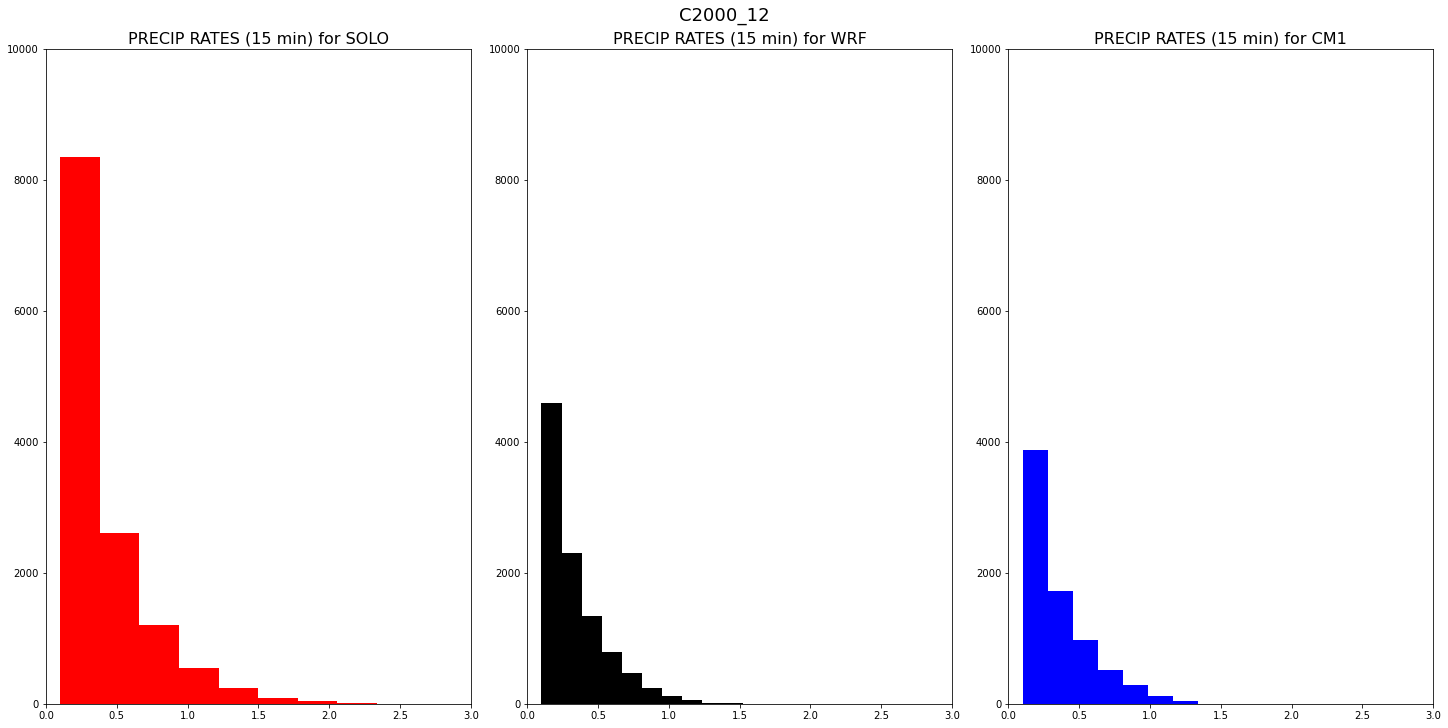

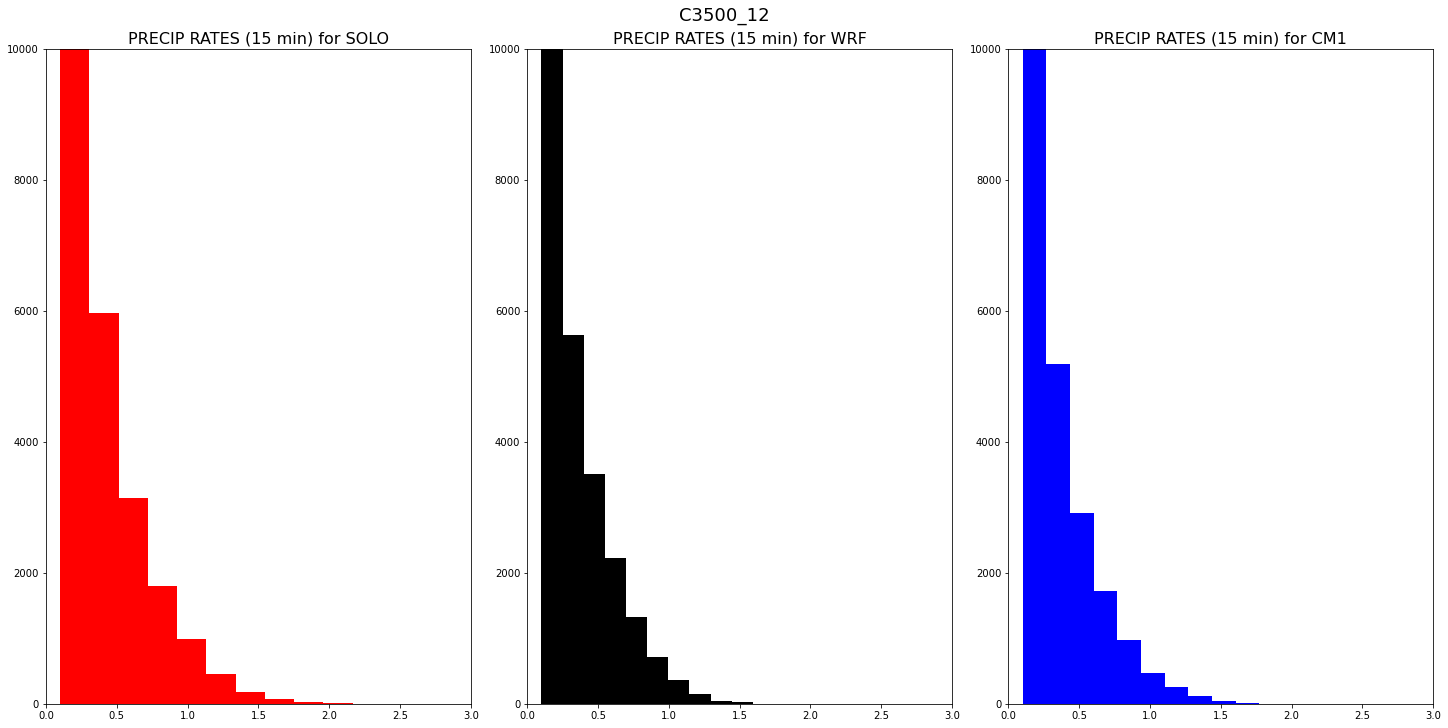

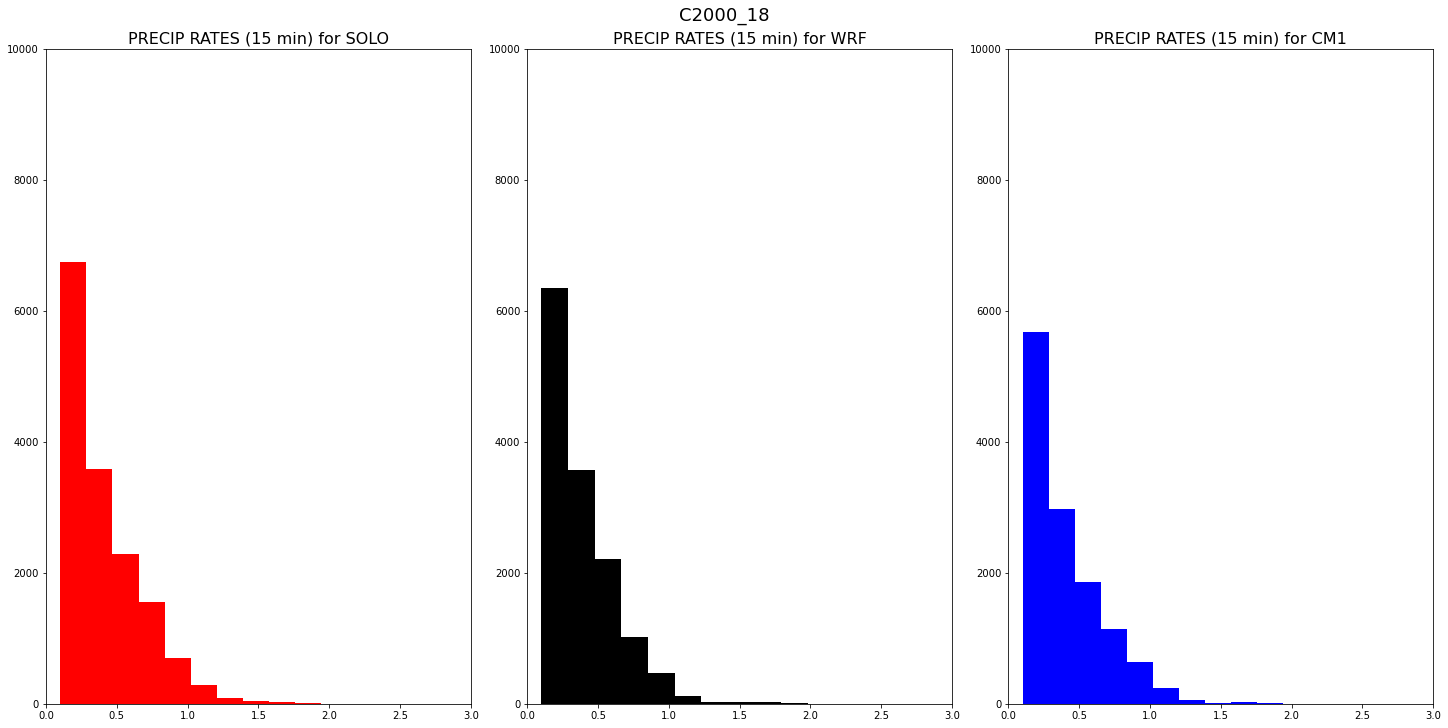

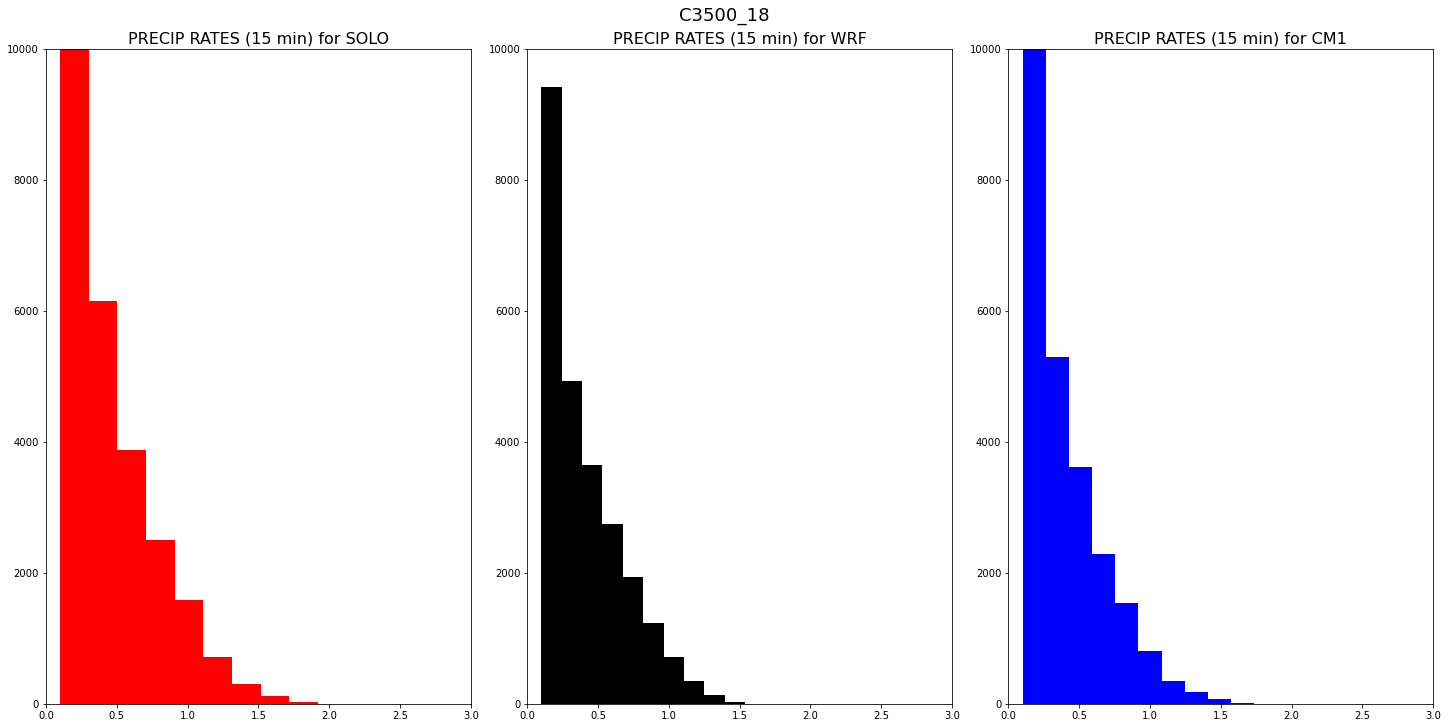

In [43]:
thres = 25.5 # mm -> inches 1"

def compute_precip(acc_precip):
    
    nt = acc_precip.shape[0]
    
    precip = np.zeros_like(acc_precip)
    
    for m in np.arange(1,nt):
        n = nt - m - 1 
        precip[n] = acc_precip[n+1] - acc_precip[n]
        
    # print("Checking:  ",(precip.sum(axis=0) - acc_precip[-1]).max())
        
    return precip/thres
    

for m, shear in enumerate(allshear):
    for n, cape in enumerate(allcape):
        label = "%s_%s" % (cape, shear)
        
        p_solo = compute_precip(solo[label]['acc_precip'])
        p_cm1  = compute_precip(cm1[label]['acc_precip'])
        p_wrf  = compute_precip(wrf[label]['acc_precip'])
    
        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

        ax[0].hist(p_solo[p_solo > 0.1], bins=10, color='red')
        ax[0].set_ylim(0.0,10000.)
        ax[0].set_xlim(0,3)
        ax[0].set_title("PRECIP RATES (15 min) for SOLO", fontsize=16)

        ax[1].hist(p_wrf[p_wrf > 0.1], bins=10, color='black')
        ax[1].set_ylim(0.0,10000.)
        ax[1].set_xlim(0,3)
        ax[1].set_title("PRECIP RATES (15 min) for WRF", fontsize=16)

        ax[2].hist(p_cm1[p_cm1 > 0.1], bins=10, color='blue')
        ax[2].set_ylim(0.0,10000.)
        ax[2].set_xlim(0,3)
        ax[2].set_title("PRECIP RATES (15 min) for CM1", fontsize=16)
        
        plt.suptitle("%s" % (label), fontsize=18)

plt.show()

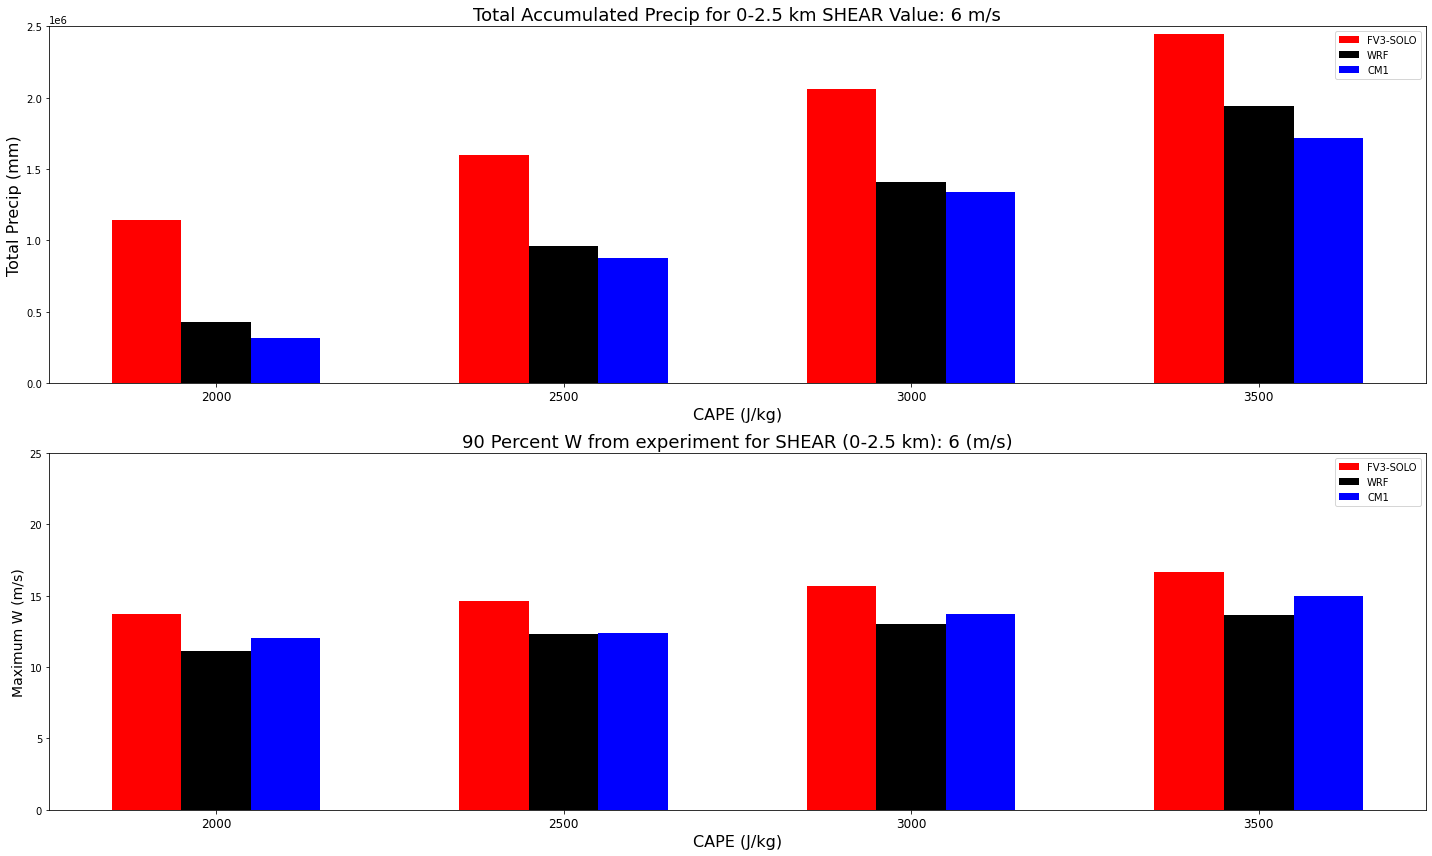

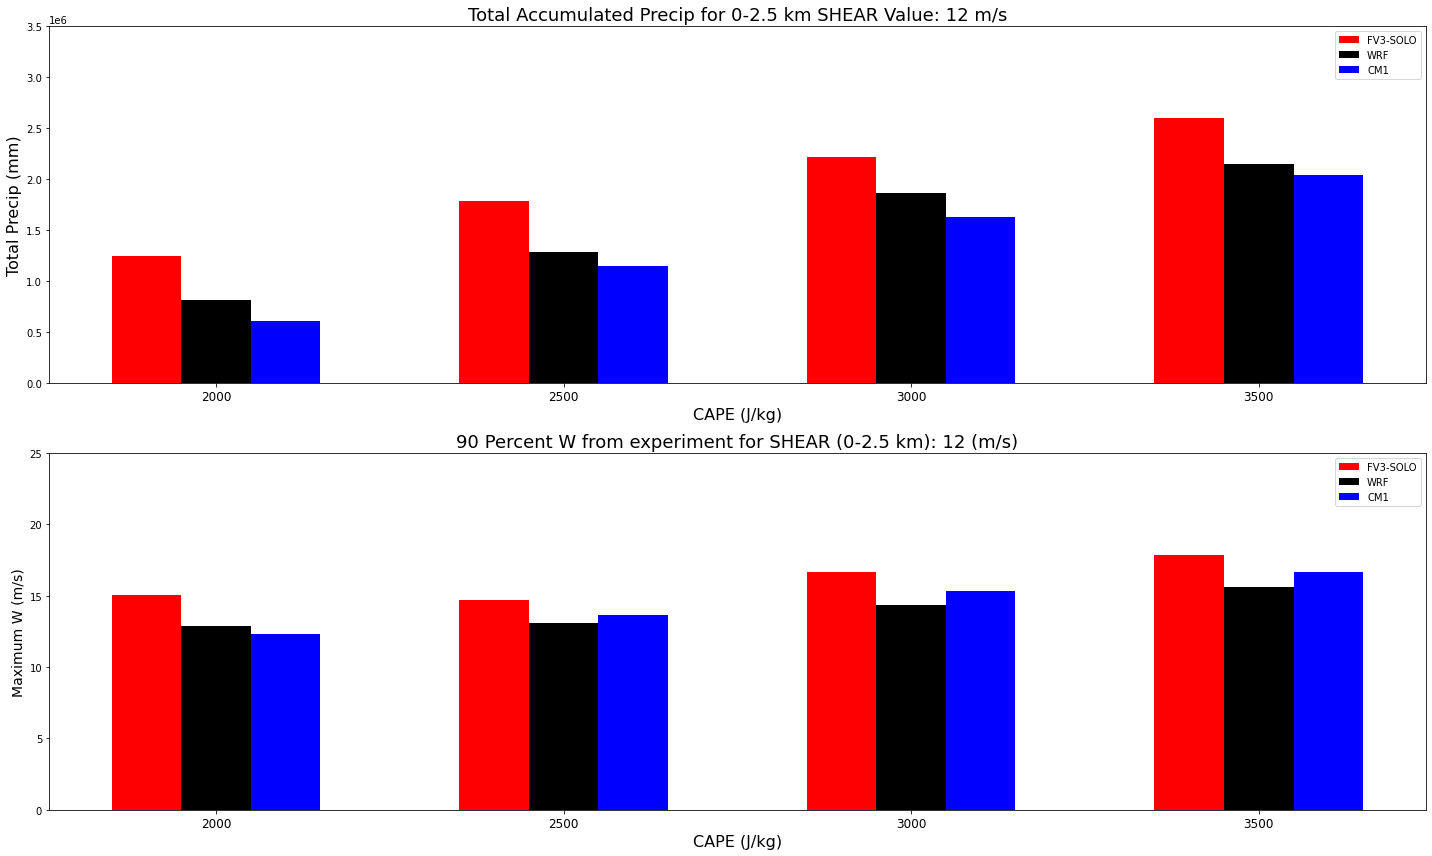

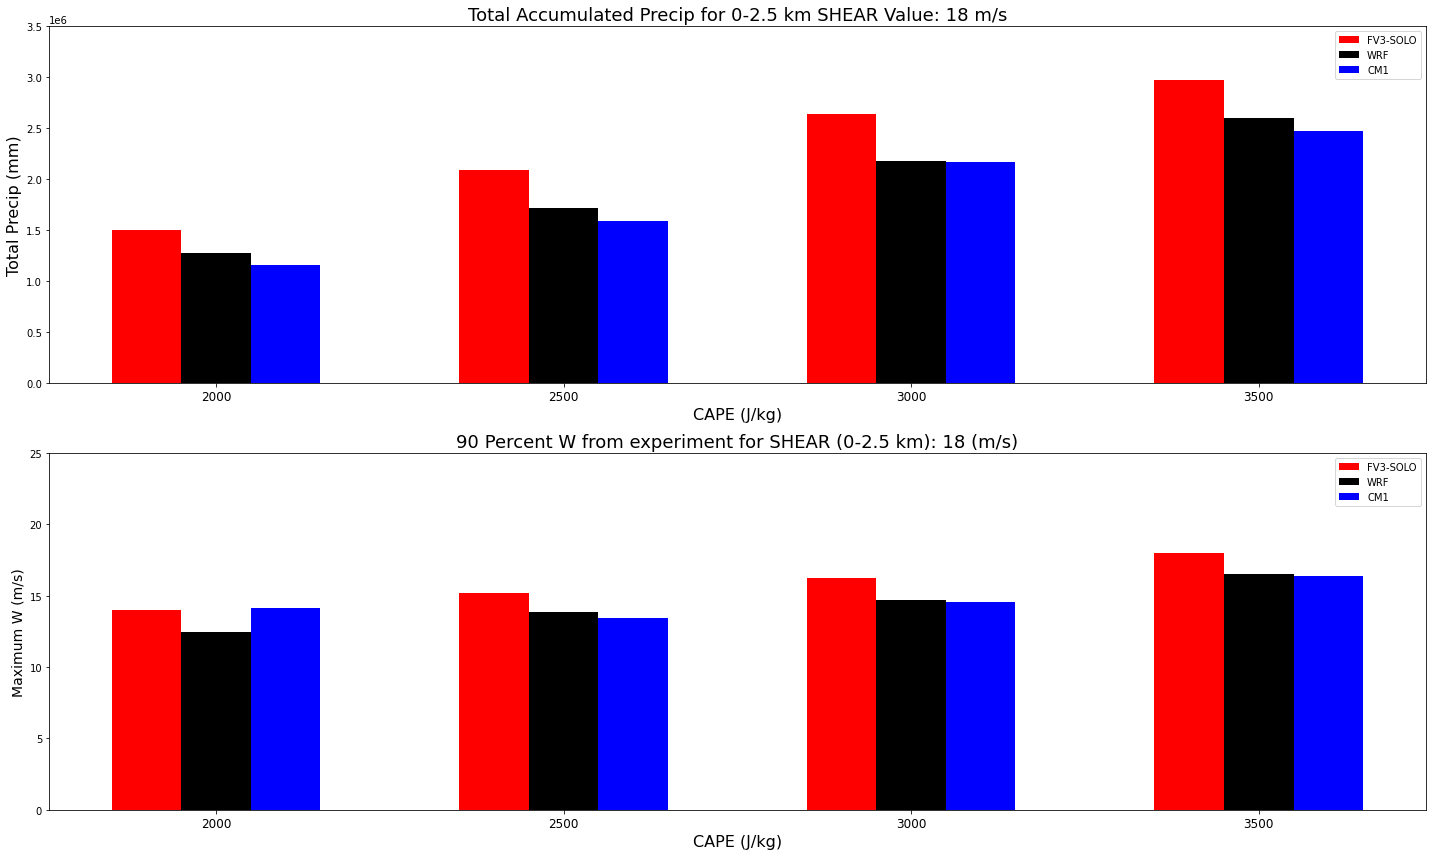

In [38]:
def wpercent(w3d, percent):
    
    w = np.sort(w3d.flatten(), kind='quicksort')
    
    n = int(len(w)*percent/100.)

    return w[n]

########################
x = np.arange(4)

wlim = [25., 25., 25.]
plim = [2.5e6, 3.5e6, 3.5e6]

allcape = ("C2000", "C2500", "C3000", "C3500")
allshear = ("06","12", "18")


labels = []
for cape in allcape:
    labels.append("%s" % (cape[1:]))
    
for n, shear in enumerate(allshear):
    
    fig, axes = plt.subplots(2,1, constrained_layout=True,figsize=(20,12))    
    slist = []
    wlist = []
    clist = []

    for cape in allcape:
        label = "%s_%s" % (cape, shear)
        
        slist.append(solo[label]['acc_precip'].sum())
        wlist.append(wrf[label]['acc_precip'].sum())
        clist.append(cm1[label]['acc_precip'].sum())
        
    ax = axes[0]

    width = 0.2  # the width of the bars
    sbar = ax.bar(x - width, slist, width, color='r', label='FV3-SOLO')
    wbar = ax.bar(x ,        wlist, width, color='k', label='WRF')
    cbar = ax.bar(x + width, clist, width, color='b', label='CM1')

    ax.set_ylabel('Total Precip (mm)', fontsize=16)
    ax.set_xlabel('CAPE (J/kg)', fontsize=16)
    ax.set_ylim(0, plim[n])
    ax.set_title('Total Accumulated Precip for 0-2.5 km SHEAR Value: %d m/s' % int(shear), fontsize=18)
    ax.set_xticks(x, labels, fontsize=12)
    ax.legend()
    
    slist = []
    wlist = []
    clist = []
    smax  = []
    wmax  = []
    cmax  = []

    for cape in allcape:
        label = "%s_%s" % (cape, shear)
                
        slist.append(wpercent(solo[label]['w'][solo[label]['w']> 3.0], 95.))
        wlist.append(wpercent(wrf[label]['w'][wrf[label]['w']> 3.0], 95.))
        clist.append(wpercent(cm1[label]['w'][cm1[label]['w']> 3.0], 95.))
        
    ax = axes[1]

    width = 0.2  # the width of the bars
    sbar = ax.bar(x - width, slist, width, color='r', label='FV3-SOLO')

    wbar = ax.bar(x ,        wlist, width, color='k', label='WRF')

    cbar = ax.bar(x + width, clist, width, color='b', label='CM1')
        
    ax.set_ylabel('Maximum W (m/s)', fontsize=14)
    ax.set_xlabel('CAPE (J/kg)', fontsize=16)
    ax.set_ylim(0, wlim[n])
    ax.set_title('90 Percent W from experiment for SHEAR (0-2.5 km): %d (m/s)' % int(shear), fontsize=18)
    ax.set_xticks(x, labels, fontsize=12)
    ax.legend()

    fig.tight_layout()

    plt.savefig('squall_3km_%s.png' % label, dpi=300)
    plt.show()

    del(sbar)
    del(wbar)
    del(cbar)



In [9]:
solo['C2000_06']['w'][solo['C2000_06']['w']> 5.0].mean()

8.693018

In [83]:
plt.savefig('SquallLine_precip_cond.png')

<Figure size 432x288 with 0 Axes>

In [21]:
ax.bar?



Signature:
ax.bar(
    x,
    height,
    width=0.8,
    bottom=None,
    *,
    align='center',
    data=None,
    **kwargs,
)
Docstring:
Make a bar plot.

The bars are positioned at *x* with the given *align*\ment. Their
dimensions are given by *height* and *width*. The vertical baseline
is *bottom* (default 0).

Many parameters can take either a single value applying to all bars
or a sequence of values, one for each bar.

Parameters
----------
x : float or array-like
    The x coordinates of the bars. See also *align* for the
    alignment of the bars to the coordinates.

height : float or array-like
    The height(s) of the bars.

width : float or array-like, default: 0.8
    The width(s) of the bars.

bottom : float or array-like, default: 0
    The y coordinate(s) of the bars bases.

align : {'center', 'edge'}, default: 'center'
    Alignment of the bars to the *x* coordinates:

    - 'center': Center the base on the *x* positions.
    - 'edge': Align the left edges of the bars w